# Кластеризация: K-Means

От теории к практике: визуализация, метод локтя, Silhouette Score, примеры на реальных данных

## 1. Импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, load_iris, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 2. Генерация синтетических данных

📊 Данные: 300 объектов, 2 признака
   Истинные кластеры: [0 1 2]


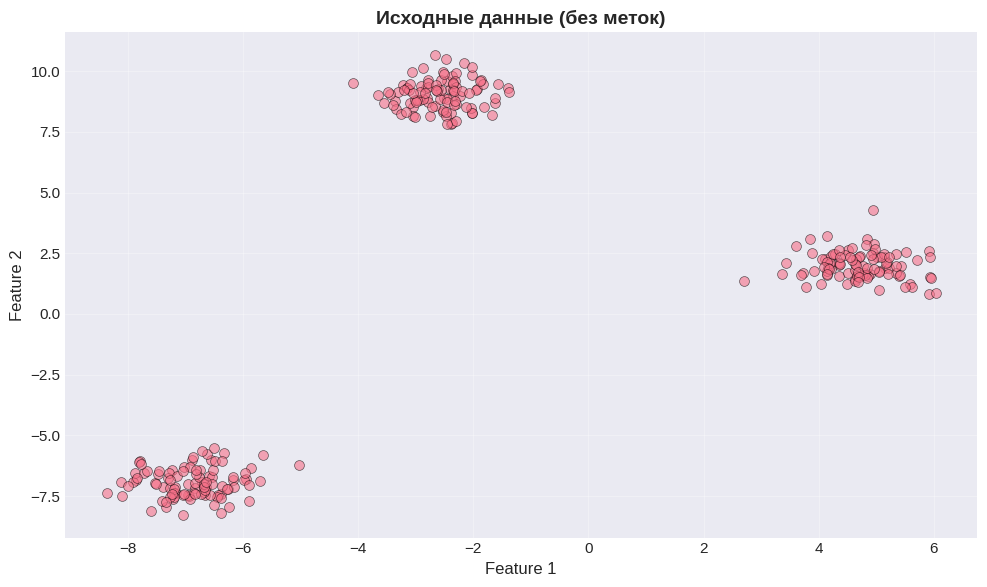

In [2]:
# Создаём 3 кластера с разным числом точек
np.random.seed(42)
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.6, random_state=42)

print(f"📊 Данные: {X.shape[0]} объектов, {X.shape[1]} признака")
print(f"   Истинные кластеры: {np.unique(y_true)}")

# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Исходные данные (без меток)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Базовый K-Means

In [3]:
# Обучаем K-Means с K=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X)

# Результаты
labels = kmeans.labels_
centers = kmeans.cluster_centers_
inertia = kmeans.inertia_

print(f"\n🎯 Результаты K-Means (K=3):")
print(f"   Inertia (внутрикластерная дисперсия): {inertia:.2f}")
print(f"   Число итераций до сходимости: {kmeans.n_iter_}")
print(f"\n   Центры кластеров:")
for i, center in enumerate(centers):
    print(f"   Кластер {i}: [{center[0]:.2f}, {center[1]:.2f}]")


🎯 Результаты K-Means (K=3):
   Inertia (внутрикластерная дисперсия): 204.07
   Число итераций до сходимости: 2

   Центры кластеров:
   Кластер 0: [-2.58, 9.03]
   Кластер 1: [-6.88, -6.94]
   Кластер 2: [4.70, 2.00]


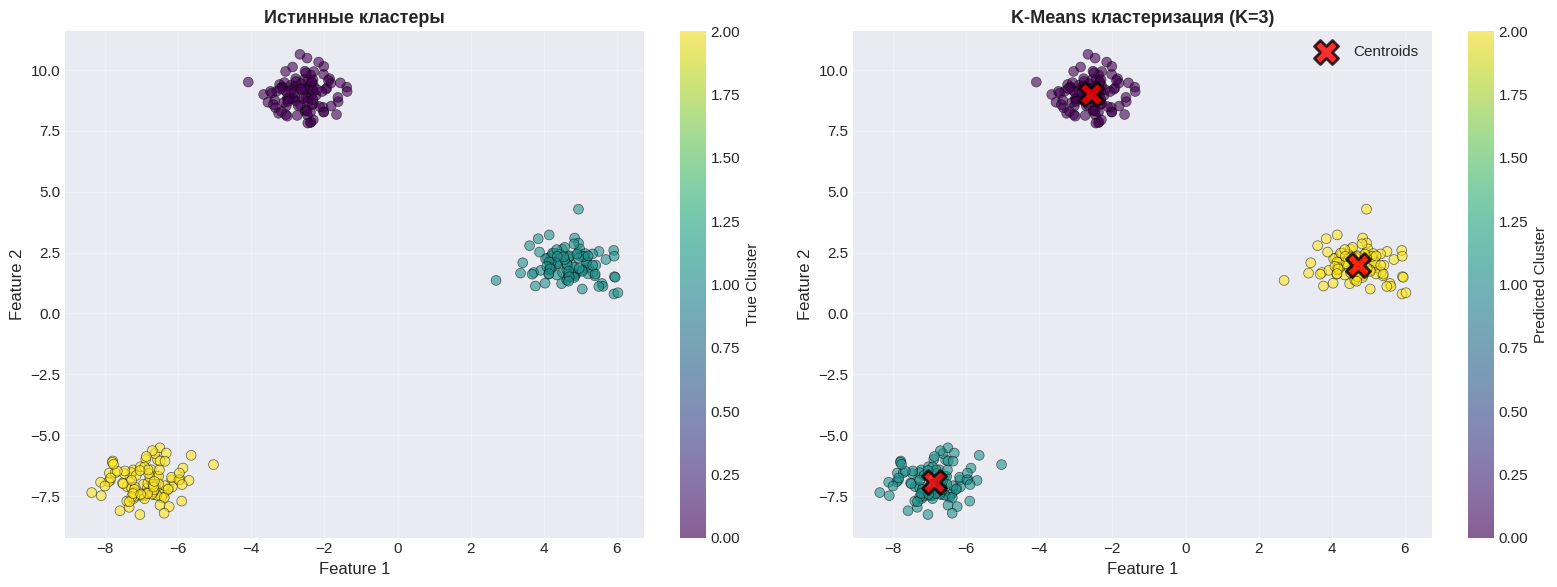


✅ Кластеры найдены правильно!


In [4]:
# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Истинные кластеры
scatter1 = axes[0].scatter(X[:, 0], X[:, 1], c=y_true, s=50, cmap='viridis',
                           alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].set_title('Истинные кластеры', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='True Cluster')

# Найденные кластеры
scatter2 = axes[1].scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis',
                           alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].scatter(centers[:, 0], centers[:, 1], c='red', s=300, alpha=0.8,
                marker='X', edgecolors='black', linewidth=2, label='Centroids')
axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
axes[1].set_title('K-Means кластеризация (K=3)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Predicted Cluster')

plt.tight_layout()
plt.show()

print("\n✅ Кластеры найдены правильно!")

## 4. Визуализация итераций K-Means

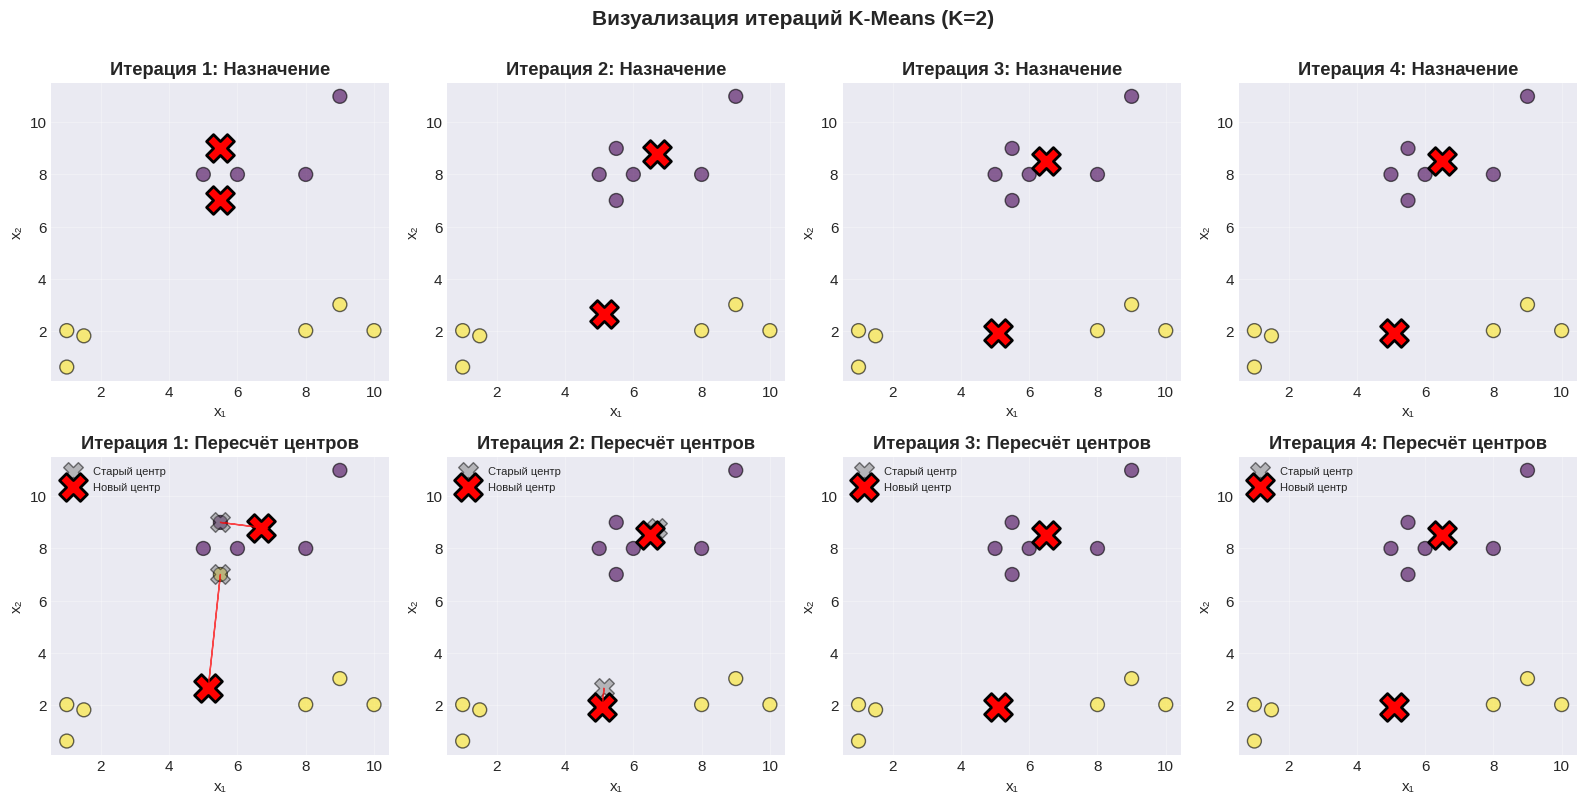


💡 Наблюдение: центры двигаются к центру масс каждого кластера


In [4]:
# Создаём простой датасет для визуализации
np.random.seed(10)
X_simple = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6], [9, 11],
                     [8, 2], [10, 2], [9, 3], [5.5, 7], [5.5, 9], [6, 8]])

# Вручную запускаем несколько итераций для визуализации
def kmeans_iteration_viz(X, n_clusters=2, n_iterations=4):
    # Начальные центры (случайно выбираем из данных)
    np.random.seed(42)
    idx = np.random.choice(len(X), n_clusters, replace=False)
    centers = X[idx].copy()

    fig, axes = plt.subplots(2, n_iterations, figsize=(16, 8))

    for iteration in range(n_iterations):
        # Назначение кластеров
        distances = np.sqrt(((X - centers[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)

        # Визуализация назначения
        axes[0, iteration].scatter(X[:, 0], X[:, 1], c=labels, s=100, cmap='viridis',
                                   alpha=0.6, edgecolors='black', linewidth=1)
        axes[0, iteration].scatter(centers[:, 0], centers[:, 1], c='red', s=400,
                                   marker='X', edgecolors='black', linewidth=2)
        axes[0, iteration].set_title(f'Итерация {iteration+1}: Назначение', fontweight='bold')
        axes[0, iteration].set_xlabel('x₁')
        axes[0, iteration].set_ylabel('x₂')
        axes[0, iteration].grid(True, alpha=0.3)

        # Пересчёт центров
        new_centers = np.array([X[labels == k].mean(axis=0) for k in range(n_clusters)])

        # Визуализация пересчёта
        axes[1, iteration].scatter(X[:, 0], X[:, 1], c=labels, s=100, cmap='viridis',
                                   alpha=0.6, edgecolors='black', linewidth=1)
        axes[1, iteration].scatter(centers[:, 0], centers[:, 1], c='gray', s=200,
                                   marker='X', edgecolors='black', linewidth=1, alpha=0.5,
                                   label='Старый центр')
        axes[1, iteration].scatter(new_centers[:, 0], new_centers[:, 1], c='red', s=400,
                                   marker='X', edgecolors='black', linewidth=2, label='Новый центр')
        # Стрелки от старых к новым центрам
        for old, new in zip(centers, new_centers):
            axes[1, iteration].arrow(old[0], old[1], new[0]-old[0], new[1]-old[1],
                                    head_width=0.3, head_length=0.2, fc='red', ec='red', alpha=0.7)
        axes[1, iteration].set_title(f'Итерация {iteration+1}: Пересчёт центров', fontweight='bold')
        axes[1, iteration].set_xlabel('x₁')
        axes[1, iteration].set_ylabel('x₂')
        axes[1, iteration].legend(loc='upper left', fontsize=8)
        axes[1, iteration].grid(True, alpha=0.3)

        centers = new_centers.copy()

    plt.suptitle('Визуализация итераций K-Means (K=2)', fontsize=15, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

kmeans_iteration_viz(X_simple, n_clusters=2, n_iterations=4)

print("\n💡 Наблюдение: центры двигаются к центру масс каждого кластера")

## 5. Метод локтя (Elbow Method)

🔬 Вычисление inertia для разных K...

K= 1: Inertia = 19884.40
K= 2: Inertia = 5335.12
K= 3: Inertia = 204.07
K= 4: Inertia = 179.33
K= 5: Inertia = 153.75
K= 6: Inertia = 131.40
K= 7: Inertia = 110.98
K= 8: Inertia =  97.23
K= 9: Inertia =  84.37
K=10: Inertia =  78.34


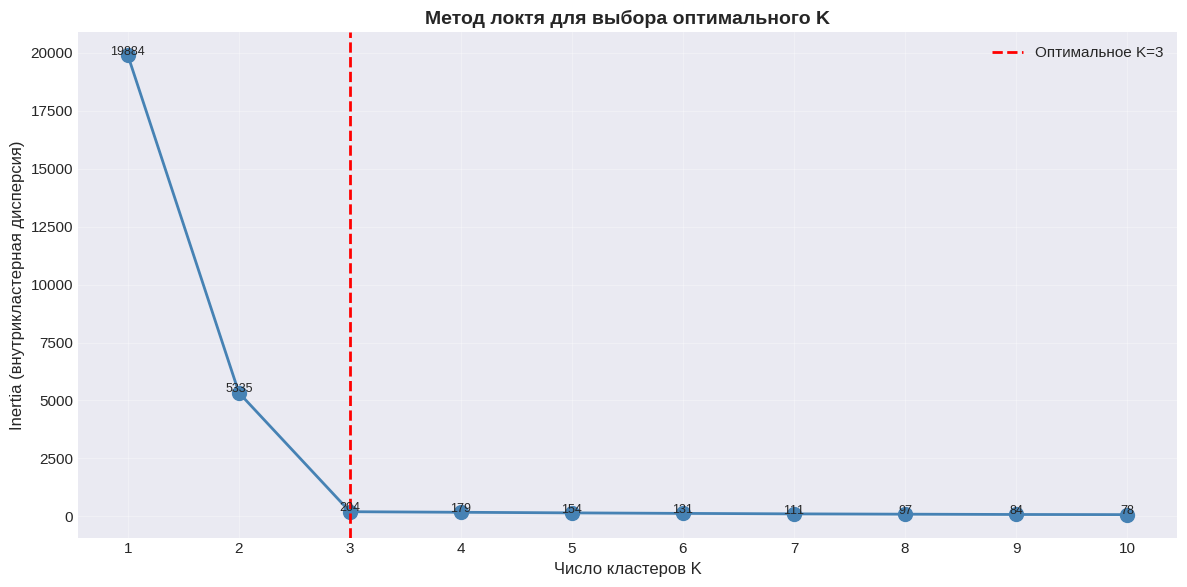


💡 'Локоть' на графике около K=3 → это оптимальное число кластеров


In [6]:
# Тестируем разные K
K_range = range(1, 11)
inertias = []

print("🔬 Вычисление inertia для разных K...\n")

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X)
    inertias.append(kmeans_temp.inertia_)
    print(f"K={k:2d}: Inertia = {kmeans_temp.inertia_:6.2f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(K_range, inertias, 'o-', linewidth=2, markersize=10, color='steelblue')
plt.axvline(x=3, color='red', linestyle='--', linewidth=2, label='Оптимальное K=3')
plt.xlabel('Число кластеров K', fontsize=12)
plt.ylabel('Inertia (внутрикластерная дисперсия)', fontsize=12)
plt.title('Метод локтя для выбора оптимального K', fontsize=14, fontweight='bold')
plt.xticks(K_range)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Добавляем значения на точки
for k, inertia in zip(K_range, inertias):
    plt.text(k, inertia + 10, f'{inertia:.0f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n💡 'Локоть' на графике около K=3 → это оптимальное число кластеров")

## 6. Silhouette Score

🔬 Вычисление Silhouette Score для разных K...

K= 2: Silhouette Score = 0.7361
K= 3: Silhouette Score = 0.9084
K= 4: Silhouette Score = 0.7042
K= 5: Silhouette Score = 0.5177
K= 6: Silhouette Score = 0.3268
K= 7: Silhouette Score = 0.3573
K= 8: Silhouette Score = 0.3666
K= 9: Silhouette Score = 0.3686
K=10: Silhouette Score = 0.3568


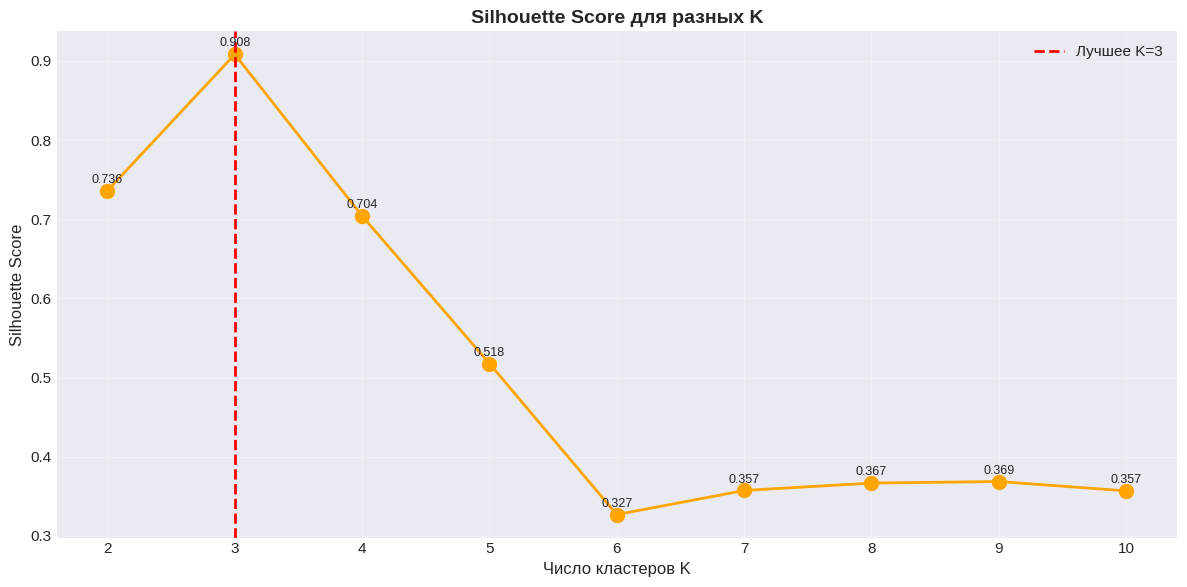


💡 Максимальный Silhouette Score при K=3 → оптимальное число кластеров


In [7]:
# Вычисляем Silhouette Score для разных K
K_range_sil = range(2, 11)  # Silhouette требует минимум 2 кластера
silhouette_scores = []

print("🔬 Вычисление Silhouette Score для разных K...\n")

for k in K_range_sil:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X)
    score = silhouette_score(X, labels_temp)
    silhouette_scores.append(score)
    print(f"K={k:2d}: Silhouette Score = {score:.4f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(K_range_sil, silhouette_scores, 'o-', linewidth=2, markersize=10, color='orange')
best_k = K_range_sil[np.argmax(silhouette_scores)]
plt.axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'Лучшее K={best_k}')
plt.xlabel('Число кластеров K', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score для разных K', fontsize=14, fontweight='bold')
plt.xticks(K_range_sil)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Добавляем значения
for k, score in zip(K_range_sil, silhouette_scores):
    plt.text(k, score + 0.01, f'{score:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n💡 Максимальный Silhouette Score при K={best_k} → оптимальное число кластеров")

## 7. Silhouette Plot (детальная визуализация)

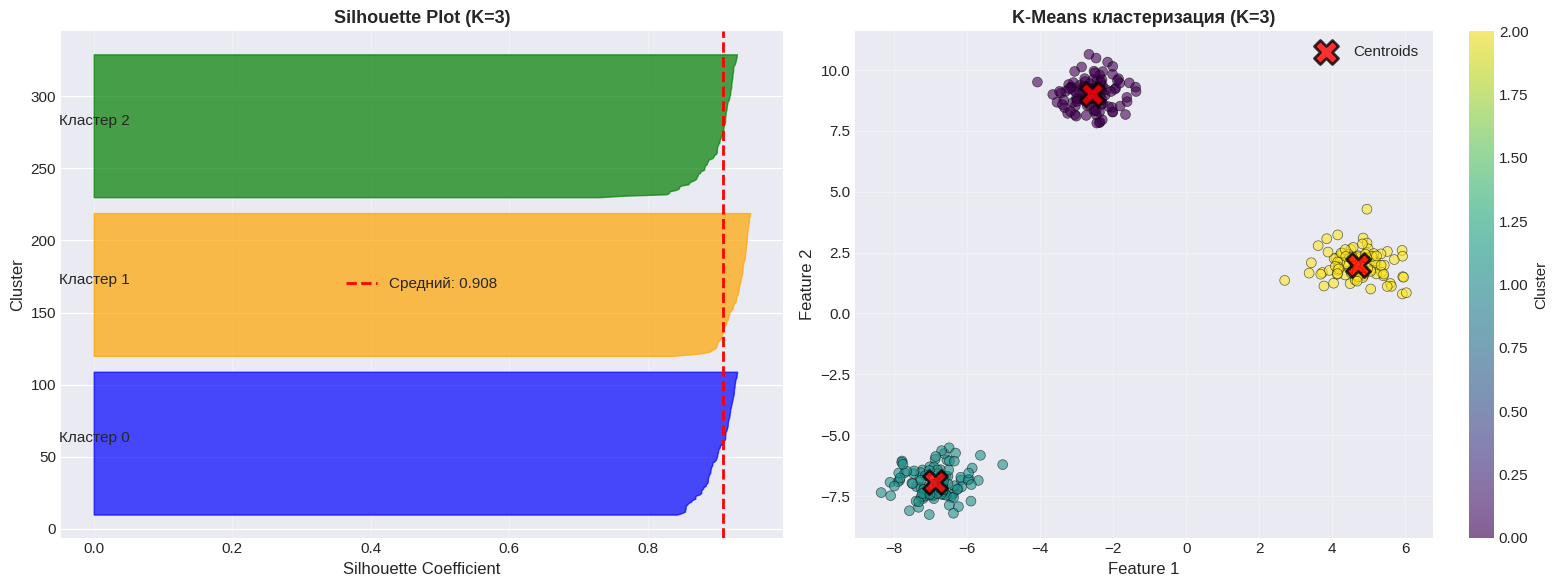


💡 Все объекты имеют положительный Silhouette Score → кластеризация хорошая


In [8]:
# Silhouette plot для K=3
kmeans_best = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_best = kmeans_best.fit_predict(X)
silhouette_vals = silhouette_samples(X, labels_best)
silhouette_avg = silhouette_score(X, labels_best)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Silhouette plot
y_lower = 10
colors = ['blue', 'orange', 'green']

for i in range(3):
    cluster_silhouette_vals = silhouette_vals[labels_best == i]
    cluster_silhouette_vals.sort()

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    axes[0].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                          facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    axes[0].text(-0.05, y_lower + 0.5 * size_cluster_i, f'Кластер {i}')

    y_lower = y_upper + 10

axes[0].axvline(x=silhouette_avg, color='red', linestyle='--', linewidth=2,
                label=f'Средний: {silhouette_avg:.3f}')
axes[0].set_xlabel('Silhouette Coefficient', fontsize=12)
axes[0].set_ylabel('Cluster', fontsize=12)
axes[0].set_title('Silhouette Plot (K=3)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='x')

# Scatter plot
scatter = axes[1].scatter(X[:, 0], X[:, 1], c=labels_best, s=50, cmap='viridis',
                         alpha=0.6, edgecolors='black', linewidth=0.5)
centers_best = kmeans_best.cluster_centers_
axes[1].scatter(centers_best[:, 0], centers_best[:, 1], c='red', s=300, alpha=0.8,
                marker='X', edgecolors='black', linewidth=2, label='Centroids')
axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
axes[1].set_title('K-Means кластеризация (K=3)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

print("\n💡 Все объекты имеют положительный Silhouette Score → кластеризация хорошая")

## 8. Анализ качества кластеризации на разных K

🔬 Анализ K-Means для разных K:

K=2: Inertia=5335.12, Silhouette=0.7361
K=3: Inertia= 204.07, Silhouette=0.9084
K=4: Inertia= 179.33, Silhouette=0.7042
K=5: Inertia= 153.75, Silhouette=0.5177


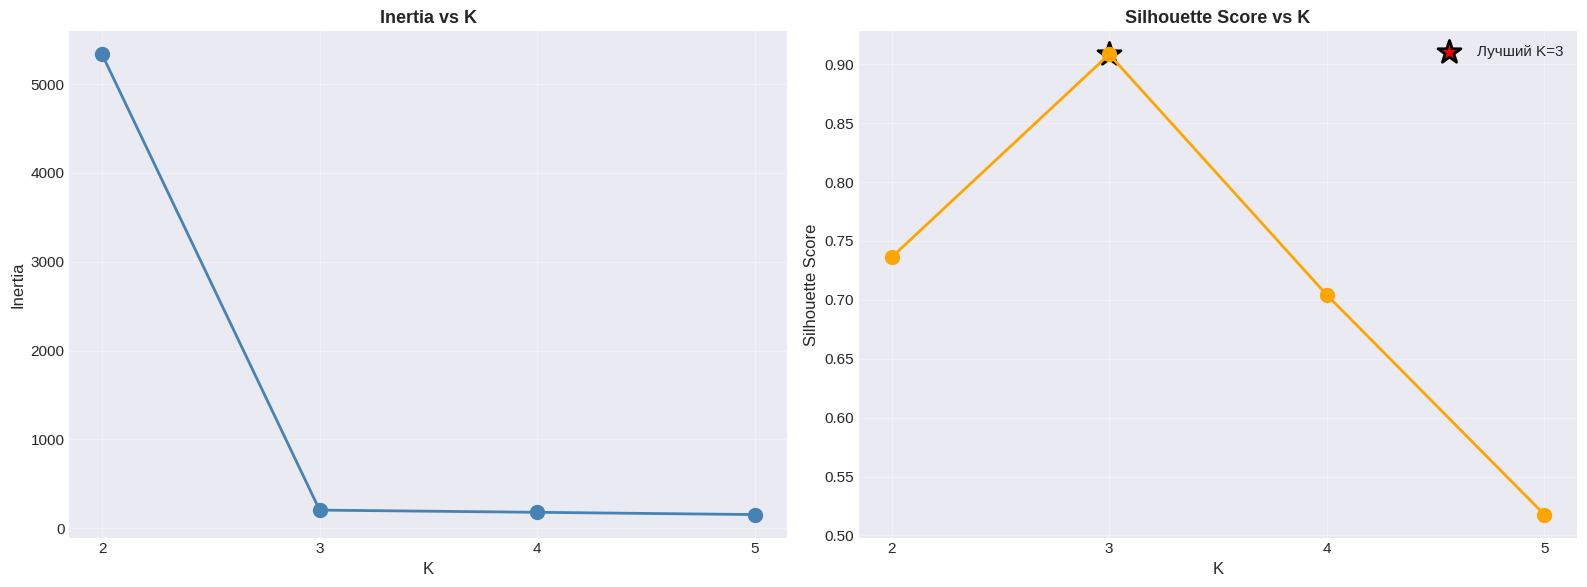


✅ Лучшее K по Silhouette Score: 3


In [9]:
# Сравнение K-Means с разными K на одном датасете
K_values = [2, 3, 4, 5]
results = []

print(f"🔬 Анализ K-Means для разных K:\n")

for k in K_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X)
    inertia_temp = kmeans_temp.inertia_
    silhouette_temp = silhouette_score(X, labels_temp)

    results.append({
        'K': k,
        'Inertia': inertia_temp,
        'Silhouette': silhouette_temp
    })

    print(f"K={k}: Inertia={inertia_temp:7.2f}, Silhouette={silhouette_temp:.4f}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Inertia
inertias = [r['Inertia'] for r in results]
axes[0].plot(K_values, inertias, 'o-', linewidth=2, markersize=10, color='steelblue')
axes[0].set_xlabel('K', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Inertia vs K', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(K_values)

# Silhouette
silhouettes = [r['Silhouette'] for r in results]
best_k_idx = np.argmax(silhouettes)
axes[1].plot(K_values, silhouettes, 'o-', linewidth=2, markersize=10, color='orange')
axes[1].scatter(K_values[best_k_idx], silhouettes[best_k_idx], s=300, c='red',
               marker='*', edgecolors='black', linewidth=2, label=f'Лучший K={K_values[best_k_idx]}')
axes[1].set_xlabel('K', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs K', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(K_values)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

print(f"\n✅ Лучшее K по Silhouette Score: {K_values[best_k_idx]}")

## 9. Когда K-Means НЕ работает

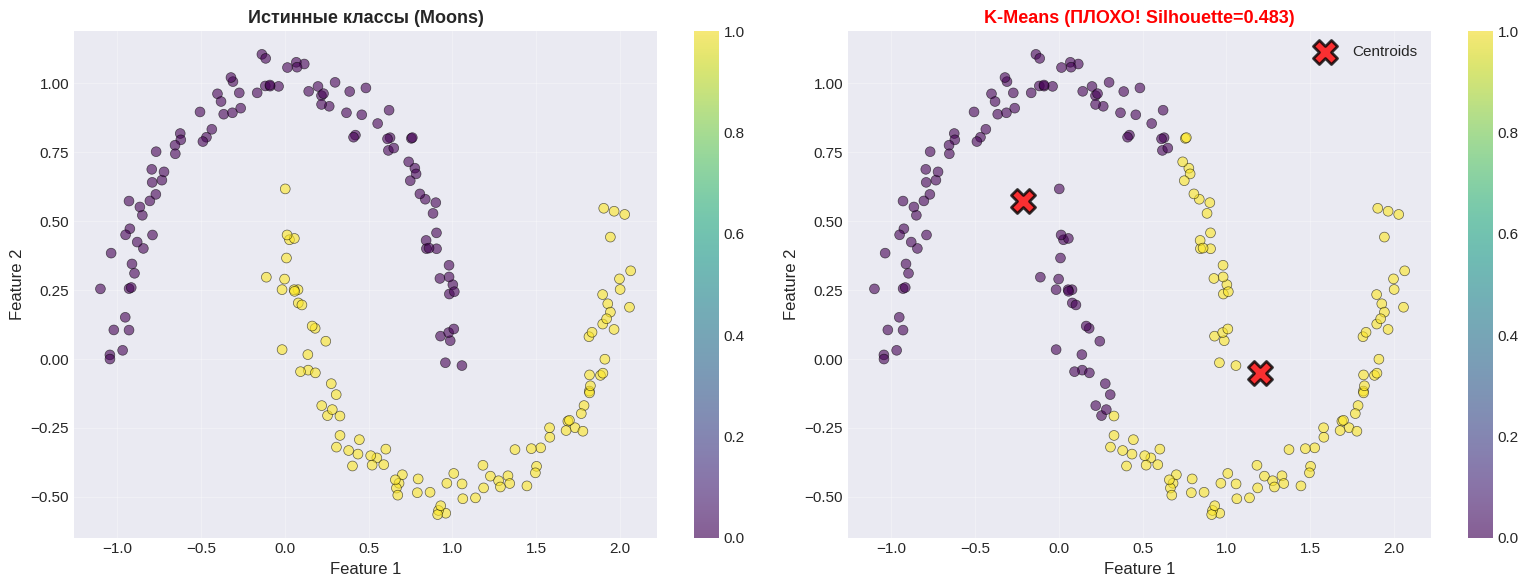


❌ K-Means плохо работает с кластерами произвольной формы!
   → Используйте DBSCAN для таких данных


In [10]:
# Данные в форме полумесяцев
X_moons, y_moons = make_moons(n_samples=200, noise=0.05, random_state=42)

# K-Means на полумесяцах
kmeans_moons = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_moons = kmeans_moons.fit_predict(X_moons)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Истинные классы
scatter1 = axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, s=50,
                           cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].set_title('Истинные классы (Moons)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0])

# K-Means результат
scatter2 = axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=labels_moons, s=50,
                           cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)
centers_moons = kmeans_moons.cluster_centers_
axes[1].scatter(centers_moons[:, 0], centers_moons[:, 1], c='red', s=300,
                alpha=0.8, marker='X', edgecolors='black', linewidth=2, label='Centroids')
axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
silhouette_moons = silhouette_score(X_moons, labels_moons)
axes[1].set_title(f'K-Means (ПЛОХО! Silhouette={silhouette_moons:.3f})',
                  fontsize=13, fontweight='bold', color='red')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

print("\n❌ K-Means плохо работает с кластерами произвольной формы!")
print("   → Используйте DBSCAN для таких данных")